In [1]:
import os
import sys
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import Word2Vec as wv
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
import torch
from torch.utils.data import DataLoader

%load_ext autoreload
%matplotlib inline

module_path = os.path.abspath(os.path.join('./syn_ant_modules'))
if module_path not in sys.path:
    sys.path.append(module_path)
import model_dataset as dataset 
import model_functions_PhaseI as functions
import model_morphology as morpho
import model_testing_PhaseI as test 
import model_training_PhaseI as train

torch.manual_seed(28)

In [2]:
#Using the GloVe pretrained encodings
#NOTE: Using 50d vectors
data = '/Users/wesleytatum/Desktop/post_doc/data/glove.6B/'
os.chdir(data)

#Loading GloVe pretrained encodings and obtaining a list of the words in the GloVe file
glove_words = []
embeddings_dict = {}
with open("glove.6B.50d.txt", 'r') as f:
    for line in f:
        values = line.split()
        glove_words.append(values[0])
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [3]:
glove_data = '/Users/wesleytatum/Desktop/post_doc/BETO/BETO2020/Ant_Syn_Scraping/'
os.chdir(glove_data)
glove_data_df = pd.read_excel('./data/CombinedSynAntList.xlsx', index_col=0)

#Adding columns for the syn and ant score labeling as well as indices
#replacing all NaN values with 0
glove_data_df['syn score'] = np.nan
glove_data_df['ant score'] = np.nan
glove_data_df['word 1 index'] = np.nan
glove_data_df['word 2 index'] = np.nan
glove_data_df = glove_data_df.fillna(0)
glove_data_df = glove_data_df[1:]

#finding which words are in our xlsx doc but not in the GloVe dictionary
glove_list1 = list(glove_data_df['word 1'])
glove_list2 = list(glove_data_df['word 2'])
glove_missing = list((set(glove_list1).difference(glove_words))) + list((set(glove_list2).difference(glove_words)))

#removing instances of twin pairs and words that are not common to the xlsx doc and GloVe dictionary
glove_data_df = glove_data_df[~glove_data_df['label'].str.contains('#', na=False)]
glove_data_df = glove_data_df[~glove_data_df['word 1'].isin(glove_missing)]
glove_data_df = glove_data_df[~glove_data_df['word 2'].isin(glove_missing)]
glove_data_df.reset_index(inplace = True, drop = True)

#cleaned lists
glove_list1 = list(glove_data_df['word 1'])
glove_list2 = list(glove_data_df['word 2'])

#preparing a list of all the words available and attributing them an index to be called
glove_common = glove_list1+glove_list2
glove_common = list(dict.fromkeys(glove_common))
glove_common = [str(i) for i in glove_common]
glove_common = sorted(glove_common)




In [4]:
#save vocab list and call it in the Pre_Trained_Embeddings
glove_common_df = pd.DataFrame(glove_common)
glove_common_df.to_csv('./data/words_list.csv', index=False)

In [5]:
#data cleaning to ensure that hand sorted "good" synonyms and antonyms are identified as such by our model
#"bad" synonym and antonym pairs are attributed the "irrelevant" tag of 0

for i in range(len(glove_data_df)): 
    
    glove_data_df['word 1 index'].iloc[i] = glove_common.index(glove_data_df['word 1'].iloc[i])
    glove_data_df['word 2 index'].iloc[i] = glove_common.index(glove_data_df['word 2'].iloc[i])
    
    glove_data_df['word 1'].iloc[i] = embeddings_dict[str(glove_data_df['word 1'].iloc[i])].tolist()
    glove_data_df['word 2'].iloc[i] = embeddings_dict[str(glove_data_df['word 2'].iloc[i])].tolist()
    
    if glove_data_df['relationship'].iloc[i] == 'syn' and glove_data_df['label'].iloc[i] == 1:
        glove_data_df['syn score'].iloc[i] = 1
        glove_data_df['ant score'].iloc[i] = -1
       
    elif glove_data_df['relationship'].iloc[i] == 'ant' and glove_data_df['label'].iloc[i] == 1:
        glove_data_df['syn score'].iloc[i] = -1 
        glove_data_df['ant score'].iloc[i] = 1
        
    else:
        glove_data_df['syn score'].iloc[i] = 0  
        glove_data_df['ant score'].iloc[i] = 0

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


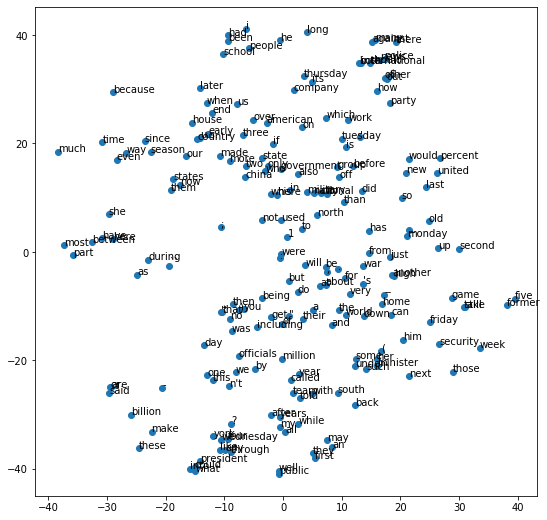

In [6]:
#visualizing word vectors
#glove_words comprises all of the words that our model has learned. Can be changed to include only a couple.
tsne = TSNE(n_components=2, random_state=0)
#words =  list(embeddings_dict.keys())
vectors = [embeddings_dict[word] for word in glove_words]
Y = tsne.fit_transform(vectors[:1000])
plt.figure(figsize = (9,9))
plt.scatter(Y[::5, 0], Y[::5, 1])

for label, x, y in zip(glove_words, Y[::5, 0], Y[::5, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords="offset points")
plt.show()

-----------------------------------------

In [7]:
#Vocabulary from Carbon corpus and Word2Vec model trained on all abstracts
#Opening contents of Word2Vec model1

data = '/Users/wesleytatum/Desktop/post_doc/data/w2v_models/all_abstracts_model/'
os.chdir(data)
model1 = wv.load('all_abstract_model.model')
vocabulary1 = list(model1.wv.vocab)

In [8]:
w2v_data = '/Users/wesleytatum/Desktop/post_doc/BETO/BETO2020/Ant_Syn_Scraping/'
os.chdir(w2v_data)
w2v_data_df = pd.read_excel('./data/CombinedSynAntList.xlsx', index_col=0)
w2v_data_df.reset_index(inplace = True, drop = True)
#data_df = data_df.rename(columns = {'Unnamed: 1':'word 1', 'Unnamed: 2':'word 2','Unnamed: 3':'relationship', 'Unnamed: 4': 'label'})

#Adding columns for the syn and ant score labeling as well as indices
#replacing all NaN values with 0
w2v_data_df['syn score'] = np.nan
w2v_data_df['ant score'] = np.nan
w2v_data_df['word 1 index'] = np.nan
w2v_data_df['word 2 index'] = np.nan
w2v_data_df = w2v_data_df.fillna(0)
w2v_data_df = w2v_data_df[1:]

#finding which words are in the pd but not in vocabulary1
list1 = list(w2v_data_df['word 1'])
list2 = list(w2v_data_df['word 2'])
missing = list((set(list1).difference(vocabulary1))) + list((set(list2).difference(vocabulary1)))

#keeping only the rows in the pd that have words in vocabulary1
w2v_data_df = w2v_data_df[~w2v_data_df['word 1'].isin(missing)]
w2v_data_df = w2v_data_df[~w2v_data_df['word 2'].isin(missing)]
w2v_data_df = w2v_data_df[~w2v_data_df['label'].str.contains('#', na=False)]

#reseting indeces after mask
w2v_data_df.reset_index(inplace = True)

#creating list of individual words that are both in vocabulary1 and excel sheet 
#dict.fromkeys() ensuring there are no duplicates
common = list(set(list1)&set(vocabulary1))+list(set(list2)&set(vocabulary1))
common = list(dict.fromkeys(common))
common = sorted(common)

In [9]:
#save vocab list and call it in the Pre_Trained_Embeddings
common_df = pd.DataFrame(common)
common_df.to_csv('./data/words_list.csv', index=False)

In [10]:
#adding the index of the words as they are positioned in the list where "common" is the list or individual words
#creating data set with the w2v weights instead of strings
#adding syn scores and ant scores for good syns and ants
#anything not "good" has a score of 0

for i in range(len(w2v_data_df)): 
    
    w2v_data_df['word 1 index'].iloc[i] = common.index(w2v_data_df['word 1'].iloc[i])
    w2v_data_df['word 2 index'].iloc[i] = common.index(w2v_data_df['word 2'].iloc[i])
    
    w2v_data_df['word 1'].iloc[i] = model1.wv.__getitem__(str(w2v_data_df['word 1'].iloc[i])).tolist()
    w2v_data_df['word 2'].iloc[i] = model1.wv.__getitem__(str(w2v_data_df['word 2'].iloc[i])).tolist()
    
    if w2v_data_df['relationship'].iloc[i] == 'syn' and w2v_data_df['label'].iloc[i] == 1:
        w2v_data_df['syn score'].iloc[i] = 1
        w2v_data_df['ant score'].iloc[i] = -1
       
    elif w2v_data_df['relationship'].iloc[i] == 'ant' and w2v_data_df['label'].iloc[i] == 1:
        w2v_data_df['syn score'].iloc[i] = -1 
        w2v_data_df['ant score'].iloc[i] = 1
        
    else:
        w2v_data_df['syn score'].iloc[i] = 0  
        w2v_data_df['ant score'].iloc[i] = 0

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


-----------------------------------------

In [11]:
#Can pick between either the glove_data_df or the w2v_data_df vector encodings in the X and Y
#Splitting our available into training and testing data

X = glove_data_df[['word 1 index', 'word 2 index']] #indices that will be used to find corresponding "feature" weights
Y = glove_data_df[['syn score', 'ant score']] #what will ultimately be predicted

x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size = 0.2, shuffle = True)

w1_train = x_train['word 1 index']
w1_test = x_test['word 1 index']
w2_train = x_train['word 2 index']
w2_test = x_test['word 2 index']
ss_train = y_train['syn score']
ss_test = y_test['syn score']
as_train = y_train['ant score']
as_test = y_test['ant score']

train_data = {'word 1 index': w1_train, 'word 2 index': w2_train, 'syn score': ss_train, 'ant score': as_train}
test_data = {'word 1 index': w1_test, 'word 2 index': w2_test, 'syn score': ss_test, 'ant score': as_test}
train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)


In [12]:
#establishing how many irrelevant (0), syn (1), and ant (-1) pairs there are in our testing data set
ss_test.value_counts()

 0.0    935
 1.0    316
-1.0     76
Name: syn score, dtype: int64

In [13]:
#establishing how many irrelevant (0), syn (-1), and ant (1) pairs there are in our testing data set (mirrors above cell)
as_test.value_counts()

 0.0    935
-1.0    316
 1.0     76
Name: ant score, dtype: int64

In [14]:
train_df.to_json('./data/Phase_I_Train.json')
test_df.to_json('./data/Phase_I_Test.json')

In [15]:
#Hyper parameters
num_epochs = 50
batch_size = 50
learning_rate = 5e-5

# Device configuration (GPU if available, otherwise CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [16]:
train_data_set = dataset.Phase_I_Train_Dataset()
test_data_set = dataset.Phase_I_Test_Dataset()

training_data_set = torch.utils.data.DataLoader(dataset = train_data_set, batch_size = batch_size, shuffle = True)
testing_data_set = torch.utils.data.DataLoader(dataset = test_data_set, batch_size = batch_size, shuffle = True)

In [17]:
%autoreload

# Instantiate NN model. 'in_dims' = dimensions of embeddings in 'common'
model = morpho.Phase_I_NN(in_dims = 50, common = glove_common).to(device)

#define the optimizer
optimizer = torch.optim.AdamW(params = model.parameters(), lr = learning_rate, amsgrad = False)


In [18]:
%autoreload

#empty list to hold loss per epoch
train_epoch_losses = []
syn_train_epoch_losses = []
ant_train_epoch_losses = []

test_epoch_losses = []
syn_test_epoch_losses = []
ant_test_epoch_losses = []

syn_test_epoch_accuracies = []
ant_test_epoch_accuracies = []

for epoch in range(num_epochs):
    print(f'epoch # {epoch}')
    
    train_epoch_loss, syn_train_epoch_loss, ant_train_epoch_loss, Lm_train_epoch_loss = train.Phase_I_train_model(model = model, training_data_set = training_data_set, optimizer = optimizer)
    
    train_epoch_losses.append(train_epoch_loss)
    syn_train_epoch_losses.append(syn_train_epoch_loss)
    ant_train_epoch_losses.append(ant_train_epoch_loss)
   
    test_epoch_loss, syn_test_epoch_loss, ant_test_epoch_loss, Lm_test_epoch_loss, syn_epoch_acc, ant_epoch_acc, syn_true, syn_predictions, ant_true, ant_predictions = test.Phase_I_eval_model(model = model, testing_data_set = testing_data_set, optimizer = optimizer)
    test_epoch_losses.append(test_epoch_loss)
    syn_test_epoch_losses.append(syn_test_epoch_loss)
    ant_test_epoch_losses.append(ant_test_epoch_loss)
    
    syn_test_epoch_accuracies.append(syn_epoch_acc)
    ant_test_epoch_accuracies.append(ant_epoch_acc)
    #test_epoch_losses.append(test_epoch_loss)
    #syn_test_epoch_losses.append(syn_test_epoch_loss)

epoch # 0
Total Epoch Testing Loss is: 75.2878461767126
Total Epoch Antonym Testing Accuracy is: 0.0
Total Epoch Synonym Testing Accuracy is: 1.3701282982328733
epoch # 1
Total Epoch Testing Loss is: 71.48468455561886
Total Epoch Antonym Testing Accuracy is: 0.0
Total Epoch Synonym Testing Accuracy is: 0.0
epoch # 2
Total Epoch Testing Loss is: 71.48286367345739
Total Epoch Antonym Testing Accuracy is: 0.0
Total Epoch Synonym Testing Accuracy is: 0.0
epoch # 3
Total Epoch Testing Loss is: 69.29621251424153
Total Epoch Antonym Testing Accuracy is: 0.0
Total Epoch Synonym Testing Accuracy is: 0.0
epoch # 4
Total Epoch Testing Loss is: 74.91502903125904
Total Epoch Antonym Testing Accuracy is: 0.0
Total Epoch Synonym Testing Accuracy is: 0.0
epoch # 5
Total Epoch Testing Loss is: 70.74975444652416
Total Epoch Antonym Testing Accuracy is: 0.0
Total Epoch Synonym Testing Accuracy is: 0.0
epoch # 6
Total Epoch Testing Loss is: 73.92476979008427
Total Epoch Antonym Testing Accuracy is: 1.2345

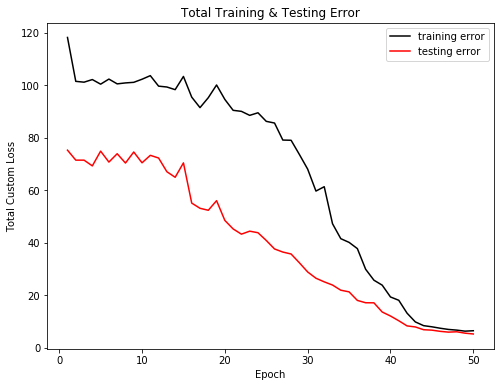

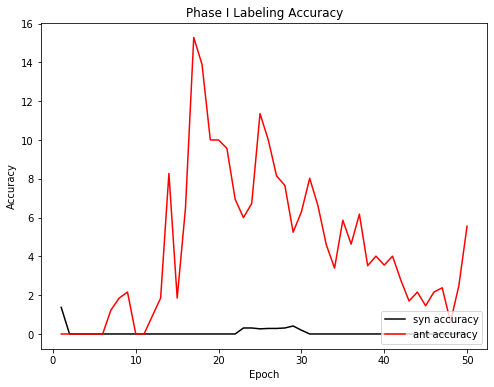

In [19]:
fig, ax = plt.subplots(figsize = (8,6))

epochs = np.arange(1, (num_epochs+1), 1)

plt.plot(epochs, train_epoch_losses, c = 'k', label = 'training error')
plt.plot(epochs, test_epoch_losses, c = 'r', label = 'testing error')
plt.legend(loc = 'upper right')
plt.title("Total Training & Testing Error")
ax.set_xlabel('Epoch')
ax.set_ylabel('Total Custom Loss')
plt.show()

fig, ax = plt.subplots(figsize = (8,6))
plt.plot(epochs, syn_test_epoch_accuracies, c = 'k', label = 'syn accuracy')
plt.plot(epochs, ant_test_epoch_accuracies, c = 'r', label = 'ant accuracy')
plt.legend(loc = 'lower right')
plt.title("Phase I Labeling Accuracy")
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
plt.show()

In [23]:
#thresholding the predicted values to be compared to the labels
syn_predictions = list(map(lambda x:1 if x >= 0.8 else x, syn_predictions))
syn_predictions = list(map(lambda x:0 if -0.8 < x < 0.8 else x, syn_predictions))
syn_predictions = list(map(lambda x:-1 if x <= -0.8 else x, syn_predictions))

ant_predictions = list(map(lambda x:1 if x >= 0.8 else x, ant_predictions))
ant_predictions = list(map(lambda x:0 if -0.8 < x < 0.8 else x, ant_predictions))
ant_predictions = list(map(lambda x:-1 if x <= -0.8 else x, ant_predictions))


#synonymy confusion matrix
syn_matrix = confusion_matrix(syn_true, syn_predictions)

#antonymy confusion matrix
ant_matrix = confusion_matrix(ant_true, ant_predictions)

In [24]:
syn_matrix

array([[  0,   2,  82],
       [  0,  31, 909],
       [  0,   6, 297]])

In [25]:
ant_matrix

array([[  0,   4, 299],
       [  0,  15, 925],
       [  0,   2,  82]])

In [25]:
#loops that have different learning rates in order to find the optimal learning rate (can use a very small lr)
#not to be used
lrs = np.linspace(1e-4, 1e-1, 150)

lr_opt = {}

for i, lr in enumerate(lrs):
    print(f'  optimization loop {i}')
    print('-----------------------------')
    
    lr_opt[i] = functions.fit(model, lr, epochs = 30)

  optimization loop 0
-----------------------------


NameError: name 'learning_rate' is not defined